In [1]:
import torch
import tqdm
import time
import os
import pickle

import numpy as np
import matplotlib.pyplot as plt

from dgcca.dgcca import DGCCA
from dgcca.anomaly_detection import CcaAnomalyDetector
from utils.load_data import load_data
from utils.load_models import load_models

In [33]:
### Config

learning_rate = 0.001
batch_size = 128
name = 'notebook'
load_features = False
load_dgcca = False

### mm-fit network parameters
num_epochs = 25
eval_every = 1
early_stop = 200
checkpoint = 200
weights_path = ''
conv_layers = 3
kernel_size = 11
kernel_stride = 2
f_in = 768 # number of input units in the first FC layer
layers = 3 # number of FC layers
hidden_units = 100 # number of hidden units
dropout = 0.0
output = 'output/' # path to output folder

### mm-fit dataset parameters
data = "../data"
num_classes = 11
window_stride = 0.2
window_length = 5
sampling_rate = 50
skeleton_sampling_rate = 30
target_sensor_sampling_rate = 50
grouped = 'GGN'
unseen_test_set = False

# set devices
parallel = False
workers = 0
if torch.cuda.is_available():
    device = 'cuda:0'
    if torch.cuda.device_count() > 1:
        print('Using {} GPUs'.format(torch.cuda.device_count()))
        parallel = True
    workers = torch.cuda.device_count() * 4

else:
    device = 'cpu'

if not os.path.exists(output):
    os.makedirs(output)

In [3]:
## define datasets
 
TRAIN_W_IDs = ['01']#, '02', '03', '04', '06', '07', '08', '16', '17', '18']
VAL_W_IDs = ['14']#, '15', '19']
if unseen_test_set:
    TEST_W_IDs = ['00', '05', '12', '13', '20']
else:
    TEST_W_IDs = ['09']#, '10', '11']
# All modalities available in MM-Fit
MODALITIES = ['sw_l_acc', 'sw_l_gyr', 'sw_l_hr', 'sw_r_acc', 'sw_r_gyr', 'sw_r_hr', 'sp_l_acc', 'sp_l_gyr',
            'sp_l_mag', 'sp_r_acc', 'sp_r_gyr', 'sp_r_mag', 'eb_l_acc', 'eb_l_gyr', 'pose_2d', 'pose_3d']
# We use a subset of all modalities in this demo.
MODALITIES_SUBSET = ['sw_l_acc', 'sw_l_gyr', 'sw_r_acc', 'sw_r_gyr', 'sp_r_acc', 'sp_r_gyr', 'eb_l_acc', 'eb_l_gyr',
                    'pose_3d']

In [4]:
if load_features:
    with open('output/'+ name + '_train' + '.pkl', 'rb') as f:
        train = pickle.load(f)
    # with open('output/'+ name + '_train' + '.npy', 'rb') as f:
    #     train_arr = np.load(f)
    #     train = {}
    #     for mod, data in zip(MODALITIES_SUBSET[0:-1], train_arr):
    #         train[mod] = torch.tensor(data)

    with open('output/'+ name + '_val' + '.pkl', 'rb') as f:
        val = pickle.load(f)

    with open('output/'+ name + '_test' + '.pkl', 'rb') as f:
        test = pickle.load(f)
else:
    train_loader, val_loader, test_loader = load_data(MODALITIES_SUBSET, data, train_ids=TRAIN_W_IDs, val_ids = VAL_W_IDs, test_ids=TEST_W_IDs, loader=True, batch_size=batch_size, window_stride=window_stride, window_length=window_length, skeleton_sampling_rate=skeleton_sampling_rate, target_sensor_sampling_rate=target_sensor_sampling_rate, workers=workers)

    models = load_models(modalities=MODALITIES_SUBSET, device=device)

    for modality, model in models.items():
        if parallel:
            models[modality] = nn.DataParallel(model)
        models[modality].eval()

    train = {}
    for modality in MODALITIES_SUBSET:
        train[modality] = []

    length = len(train_loader)
    with tqdm.tqdm(total=length) as pbar_train:
        for i, (data, labels, reps) in enumerate(train_loader):
            for modality in MODALITIES_SUBSET:
                train[modality].append(models[modality](data[modality]).detach())

            pbar_train.update(1)
            pbar_train.set_description('Batch [{}/{}]'.format(i+1, length))

    shapes = {}
    for modality, data in train.items():
        cat = torch.cat(data).double()
        train[modality] = cat.reshape((cat.shape[0], -1))
        shapes[modality] = train[modality].shape[1]

    with open('output/'+ name + '_train' + '.pkl', 'wb') as f:
        pickle.dump(train, f, protocol=4)

    val = {}
    for modality in MODALITIES_SUBSET:
        val[modality] = []

    length = len(val_loader)
    with tqdm.tqdm(total=length) as pbar_val:
        for i, (data, labels, reps) in enumerate(val_loader):
            for modality in MODALITIES_SUBSET:
                val[modality].append(models[modality](data[modality]).detach())
            pbar_val.update(1)
            pbar_val.set_description('Batch [{}/{}]'.format(i+1, length))

    for modality, data in val.items():
        cat = torch.cat(data).double()
        val[modality] = cat.reshape((cat.shape[0], -1))

    with open('output/'+ name + '_val' + '.pkl', 'wb') as f:
        pickle.dump(val, f, protocol=4)

    test = {}
    for modality in MODALITIES_SUBSET:
        test[modality] = []

    length = len(test_loader)
    with tqdm.tqdm(total=length) as pbar_test:
        for i, (data, labels, reps) in enumerate(test_loader):
            for modality in MODALITIES_SUBSET:
                test[modality].append(models[modality](data[modality]).detach())
            pbar_test.update(1)
            pbar_test.set_description('Batch [{}/{}]'.format(i+1, length))

    for modality, data in test.items():
        cat = torch.cat(data).double()
        test[modality] = cat.reshape((cat.shape[0], -1))

    with open('output/'+ name + '_test' + '.pkl', 'wb') as f:
        pickle.dump(test, f, protocol=4)

Batch [137/137]: 100%|██████████| 137/137 [06:44<00:00,  2.95s/it]


In [23]:
del train['pose_3d']
del val['pose_3d']
del test['pose_3d']

In [37]:
hidden_layers = [256, 512]
cca_input_dim = 64
cca_lr = 1e-2
cca_epochs = 3
cca_dim = 10
cca_truncparam = 1000
cca_window_size = 150

layer_sizes = [[modality.shape[1]] for modality in train.values()]
for layers in layer_sizes:
    layers.extend(hidden_layers)

In [26]:
dgcca = DGCCA(layer_sizes, cca_input_dim, device=device)
if load_dgcca:
    dgcca.load_checkpoint('output/{}_dgcca.pth'.format(name))
dgcca.train([output for output in train.values()], cca_epochs, lr=cca_lr, cca_dim=cca_dim, cca_hidden_dim=cca_truncparam, incremental=False)
if not load_dgcca:
    dgcca.save_checkpoint('output/{}_dgcca.pth'.format(name))

Embedding training set:: 100%|██████████| 571/571 [00:25<00:00, 22.20it/s]
Decomposed data matrix for view 0
Decomposed data matrix for view 1
Decomposed data matrix for view 2
Decomposed data matrix for view 3
Decomposed data matrix for view 4
Decomposed data matrix for view 5
Decomposed data matrix for view 6
Decomposed data matrix for view 7
Decomposed M_tilde / solved for G
Solved for U in view 0
Solved for U in view 1
Solved for U in view 2
Solved for U in view 3
Solved for U in view 4
Solved for U in view 5
Solved for U in view 6
Solved for U in view 7


Generating noise...
Getting data embeddings...
Getting noise embeddings...
Computing (6,7) threshold: 100%|██████████| 28/28.0 [00:38<00:00,  1.39s/it]


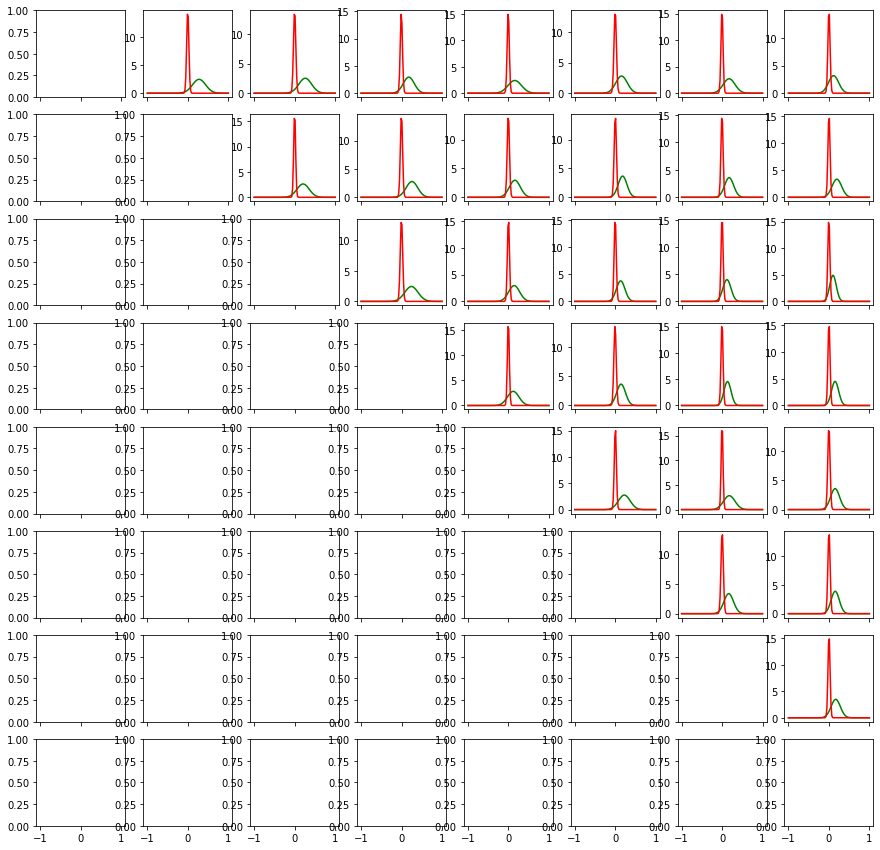

In [50]:
detector = CcaAnomalyDetector(dgcca)

load_detector = False

if load_detector:
    detector.thresholds = np.load('output/adthresh.npy')
    detector.classifier = detector.threshold_classifier
else:
    fig = detector.train([modality for modality in val.values()], stride=10, window=cca_window_size, plot=True)

In [54]:
def evaluate_single(data, labels, grace=0):
    pred = detector.detect_anomalies(data, grace=grace)
    #print(pred)
    tp = ((labels == pred) & (pred == True)).sum()
    tn = ((labels == pred) & (pred == False)).sum()
    fp = ((labels != pred) & (pred == True)).sum()
    fn = ((labels != pred) & (pred == False)).sum()
    return (tp, tn, fp, fn)

def reduce_data(data):
    reduced = []
    for modality in MODALITIES_SUBSET:
        reduced.append(models[modality](data[modality]).detach().double())
    reduced = [red.reshape((red.shape[0], -1)) for red in reduced]
    return reduced

def noise_like(data):
    mean = data.mean().item()
    std = data.std().item()
    return torch.tensor(np.random.default_rng().normal(mean, std, data.shape))

def evaluate(loader, n=10, corrupted=1, grace=0):
    results = np.zeros((4))
    with tqdm.tqdm(total=n) as eval_bar:
        for i in range(n):
            starttime = time.time()
            data, _, _ = next(iter(loader))
            data = reduce_data(data)
            data = data[0:-1]
            inftime = time.time() - starttime
            labels = np.array([True]*(len(data)))
            for modality in np.random.default_rng().choice(len(data), size=corrupted, replace=False):
                data[modality] = noise_like(data[modality])
                labels[modality] = False
            #print(labels)
            results += np.array(evaluate_single(data, labels, grace=grace))
            alltime = time.time() - starttime
            eval_bar.update(1)
            eval_bar.set_description('Sample [{}/{}] | Accuracy: {:.1%} | Precision: {:.1%} | Recall: {:.1%}'.format(i+1, n, (results[0] + results[1])/results.sum(), results[0]/(results[0]+results[2]), results[0]/(results[0]+results[3])))
    return results

In [44]:
train_loader, _, test_loader = load_data(MODALITIES_SUBSET, data, train_ids=TRAIN_W_IDs, val_ids = VAL_W_IDs, test_ids=TEST_W_IDs, loader=True, batch_size=cca_window_size, window_stride=window_stride, window_length=window_length, skeleton_sampling_rate=skeleton_sampling_rate, target_sensor_sampling_rate=target_sensor_sampling_rate, workers=workers)

In [55]:
results = evaluate(test_loader, 30, 2, grace=2)
results

Sample [30/30] | Accuracy: 82.5% | Precision: 100.0% | Recall: 76.7%: 100%|██████████| 30/30 [04:38<00:00,  9.28s/it]


array([138.,  60.,   0.,  42.])